In [1]:
import os

import cv2
import onnx
from onnx2keras import onnx_to_keras
from onnx_pytorch import code_gen

from pytorchGenerator.model import Model
import numpy as np
import onnxruntime
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt

In [2]:
def sigmoid(input):
    return 1 / (1 + np.exp(-input))

Set model settings

In [3]:
onnx_model = "models/supercombo.onnx"
modelType = "Keras"
# modelType = "Pytorch"

Set variables

In [4]:
# tf.compat.v1.disable_v2_behavior()
plan_start_idx = 0
plan_end_idx = 4955

lanes_start_idx = plan_end_idx
lanes_end_idx = lanes_start_idx + 528

lane_lines_prob_start_idx = lanes_end_idx
lane_lines_prob_end_idx = lane_lines_prob_start_idx + 8

In [5]:
data = np.load('data/numpy.npz')

datasize = data['inputImgs'].shape[0]

inputImgs_data = data['inputImgs']
bigInputImgs_data = data['bigInputImgs']
desire_data = data['desire']
trafficConvention_data = data['trafficConvention']
initialState_data = data['initialState']
output_data = data['output']

trafficConventionShape = trafficConvention_data.shape
trafficConvention_data_inverted = trafficConvention_data[::, ::-1]
trafficConvention_data_ones = np.ones(trafficConventionShape)
trafficConvention_data_zeros = np.zeros(trafficConventionShape)

desireShape = desire_data.shape
desire_data_inverted = desire_data.astype(int)
desire_data_inverted = ~desire_data_inverted+2
desire_data_inverted = desire_data.astype(np.float32)
desire_data_ones = np.ones(desireShape)
desire_data_zeros = np.zeros(desireShape)

In [6]:
if modelType == "Keras":
    model = tf.keras.models.load_model("models/keras")
    result = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result2 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_inverted,
                                                          "initial_state": initialState_data}))
    result3 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_ones,
                                                          "initial_state": initialState_data}))
    result4 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                          "big_input_imgs": bigInputImgs_data,
                                                          "desire": desire_data,
                                                          "traffic_convention": trafficConvention_data_zeros,
                                                          "initial_state": initialState_data}))
    result5 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_inverted,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result6 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_ones,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
    result7 = model.predict(tf.data.Dataset.from_tensors({"input_imgs": inputImgs_data,
                                                         "big_input_imgs": bigInputImgs_data,
                                                         "desire": desire_data_zeros,
                                                         "traffic_convention": trafficConvention_data,
                                                         "initial_state": initialState_data}))
elif modelType == "Pytorch":
    model = torch.load('models/supercombo.pt')
    model.eval()

    result = model(torch.from_numpy(inputImgs_data), torch.from_numpy(bigInputImgs_data),
                   torch.from_numpy(desire_data), torch.from_numpy(trafficConvention_data),
                   torch.from_numpy(initialState_data))
    result = result.detach().numpy()

In [7]:
def calculateAccuracy(result, pb, type):
    lane_lines_prob = sigmoid(result[:, lane_lines_prob_start_idx + 1:lane_lines_prob_end_idx:2])
    probability = (lane_lines_prob >= pb).astype(int)
    accuracy = np.sum(probability == output_data) / (len(output_data) * len(output_data[0]))
    print("Accuracy on " + type + " examples: {}%".format(accuracy * 100))
    return lane_lines_prob

In [8]:
probabilityPoint = 0.7

lane_lines_prob = calculateAccuracy(result, probabilityPoint, "default")
lane_lines_prob2 = calculateAccuracy(result2, probabilityPoint, "Inverted Traffic Convention")
lane_lines_prob3 = calculateAccuracy(result3, probabilityPoint, "Ones Traffic Convention")
lane_lines_prob4 = calculateAccuracy(result4, probabilityPoint, "Zeros Traffic Convention")
lane_lines_prob5 = calculateAccuracy(result5, probabilityPoint, "Inverted Desire")
lane_lines_prob6 = calculateAccuracy(result6, probabilityPoint, "Ones Desire")
lane_lines_prob7 = calculateAccuracy(result7, probabilityPoint, "Zeros Desire")

Accuracy on default examples: 94.82323232323232%
Accuracy on Inverted Traffic Convention examples: 95.83333333333334%
Accuracy on Ones Traffic Convention examples: 94.94949494949495%
Accuracy on Zeros Traffic Convention examples: 95.83333333333334%
Accuracy on Inverted Desire examples: 94.82323232323232%
Accuracy on Ones Desire examples: 50.75757575757576%
Accuracy on Zeros Desire examples: 94.82323232323232%


In [9]:
def plotResults(prob, x, number, label):
    y = np.array(prob)
    plt.plot(x, y, label=label)
    if number == 0:
        plt.title("left far")
    if number == 1:
        plt.title("left near")
    if number == 2:
        plt.title("right near")
    if number == 3:
        plt.title("right far")

Traffic Convention


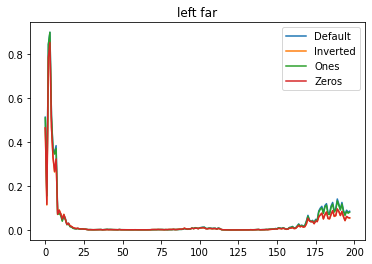

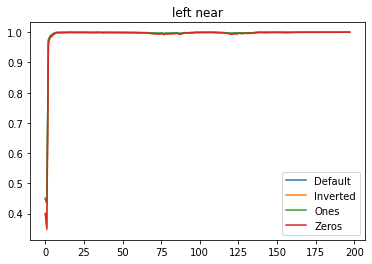

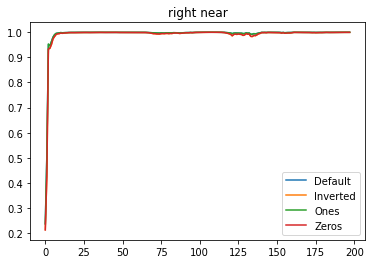

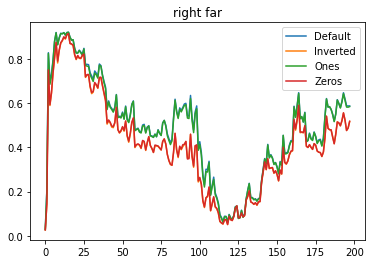

Desire


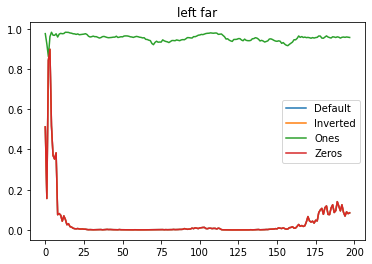

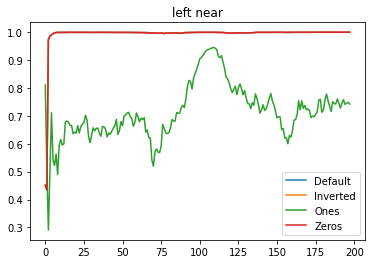

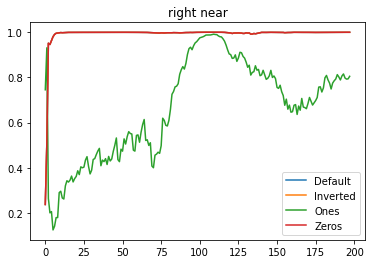

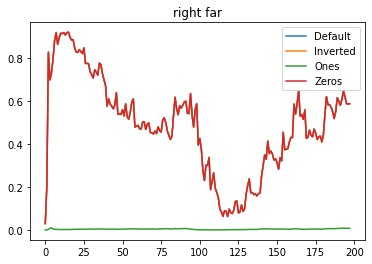

In [10]:
x = np.arange(0, datasize)
print("Traffic Convention")
for n in range(4):
    plotResults(np.column_stack(lane_lines_prob)[n], x, n, "Default")
    plotResults(np.column_stack(lane_lines_prob2)[n], x, n, "Inverted")
    plotResults(np.column_stack(lane_lines_prob3)[n], x, n, "Ones")
    plotResults(np.column_stack(lane_lines_prob4)[n], x, n, "Zeros")
    plt.legend()
    plt.show()

print("Desire")
for n in range(4):
    plotResults(np.column_stack(lane_lines_prob)[n], x, n, "Default")
    plotResults(np.column_stack(lane_lines_prob5)[n], x, n, "Inverted")
    plotResults(np.column_stack(lane_lines_prob6)[n], x, n, "Ones")
    plotResults(np.column_stack(lane_lines_prob7)[n], x, n, "Zeros")
    plt.legend()
    plt.show()